# Stap 1: Importeren van de benodigde packages

In [1]:
import os
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
from zipfile import ZipFile
from shutil import copyfile
import numpy as np
import tensorflow as tf
from PIL import Image
from keras.api.applications import MobileNetV2
from keras.src.legacy.preprocessing.image import ImageDataGenerator

/home/codespace/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-04 18:19:45.125796: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 18:19:45.385625: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730744385.530193   38327 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730744385.626097   38327 cuda_blas.cc:1418] Unable 

# Stap 2: Laad het GPT-2 model

In [2]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tekst_model = GPT2LMHeadModel.from_pretrained('gpt2')
tekst_model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

# Stap 3: Functie om een persoon te herkennen in een afbeelding
Hier definiëren we de functie herken_persoon, die een afbeelding als invoer accepteert.

In [ ]:
def herken_persoon(afbeelding_pad):
    # Stap 1: Uitpakken en dataset splitsen
    werkmap = os.getcwd()  # Huidige werkmap opslaan

    # Zip-bestand uitpakken
    with ZipFile(os.path.join(werkmap, 'pins-face-recognition.zip'), 'r') as zipobject:
        zipobject.extractall()

    # Mappen maken voor training en testing
    train_map = os.path.join(werkmap, 'train')
    test_map = os.path.join(werkmap, 'test')
    os.makedirs(train_map, exist_ok=True)
    os.makedirs(test_map, exist_ok=True)

    # Dataset configureren
    train_ratio = 0.8
    test_ratio = 0.2
    bron_map = os.path.join(werkmap, '105_classes_pins_dataset')
    map_lijst = os.listdir(bron_map)

    # Dataset splitsen in training en testing
    for map_naam in map_lijst:
        data_map = os.listdir(os.path.join(bron_map, map_naam))
        np.random.shuffle(data_map)
        os.makedirs(os.path.join(train_map, map_naam), exist_ok=True)
        os.makedirs(os.path.join(test_map, map_naam), exist_ok=True)
        
        train_data = data_map[:int(len(data_map) * train_ratio)]
        test_data = data_map[-int(len(data_map) * test_ratio):]
    
        for afbeelding in train_data:
            copyfile(os.path.join(bron_map, map_naam, afbeelding), os.path.join(train_map, map_naam, afbeelding))
        
        for afbeelding in test_data:
            copyfile(os.path.join(bron_map, map_naam, afbeelding), os.path.join(test_map, map_naam, afbeelding))

    # Stap 2: Model en data-generatie instellen
    rows, cols = 128, 128  # Verklein de afbeelding
    getraind_model = MobileNetV2(input_shape=(rows, cols, 3), include_top=False, weights='imagenet')
    
    # Freeze the first few layers
    for layer in getraind_model.layers[:100]:  # Freeze first 100 layers
        layer.trainable = False
    
    laatste_laag = getraind_model.get_layer('out_relu')
    laatste_laag_output = laatste_laag.output

    # Callback om te stoppen bij 98% nauwkeurigheid
    class mijnCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('accuracy') > 0.98:
                print("\nBereikt 98% nauwkeurigheid, training stopt.")
                self.model.stop_training = True

    callbacks = [
        mijnCallback(),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]

    # Model samenstellen
    x = tf.keras.layers.GlobalAveragePooling2D()(laatste_laag_output)
    x = tf.keras.layers.Dropout(0.5)(x)  # Dropout kan ook iets verlaagd worden
    x = tf.keras.layers.Dense(105, activation='softmax')(x)
    model = tf.keras.Model(getraind_model.input, x)

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

    # Data-generator instellen
    train_generator = ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2,
                                         horizontal_flip=True, rotation_range=40,
                                         width_shift_range=0.1, height_shift_range=0.1)
    test_generator = ImageDataGenerator(rescale=1/255)

    train_data = train_generator.flow_from_directory(train_map, target_size=(rows, cols), class_mode='categorical', batch_size=32)
    test_data = test_generator.flow_from_directory(test_map, target_size=(rows, cols), class_mode='categorical', batch_size=32)

    # Model trainen
    model.fit(train_data, validation_data=test_data, epochs=50,
              callbacks=callbacks, verbose=1)

    # Optioneel: Model voorspelling
    img = tf.keras.preprocessing.image.load_img(afbeelding_pad, target_size=(rows, cols))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Maak een batch
    img_array = img_array / 255.

    score = model.predict(img_array)

    klasse_namen = list(train_data.class_indices.keys())
    return klasse_namen[np.argmax(score)][5:].title()

# Stap 4: Functie om een beschrijving te genereren
Nu definiëren we de functie genereer_beschrijving, die de naam van de persoon gebruikt om een beschrijving te genereren.

In [4]:
def genereer_beschrijving(naam_persoon):
    input_tekst = f"{naam_persoon}. Dit is een beroemd figuur. Geef hier een korte biografie over deze persoon en zijn werk."
    input_ids = tokenizer.encode(input_tekst, return_tensors='pt')

    with torch.no_grad():
        output = tekst_model.generate(
            input_ids, 
            max_length=150, 
            num_beams=5, 
            no_repeat_ngram_size=2, 
            early_stopping=True
        )
    beschrijving = tokenizer.decode(output[0], skip_special_tokens=True)
    return beschrijving

# Stap 5: Alles uitvoeren

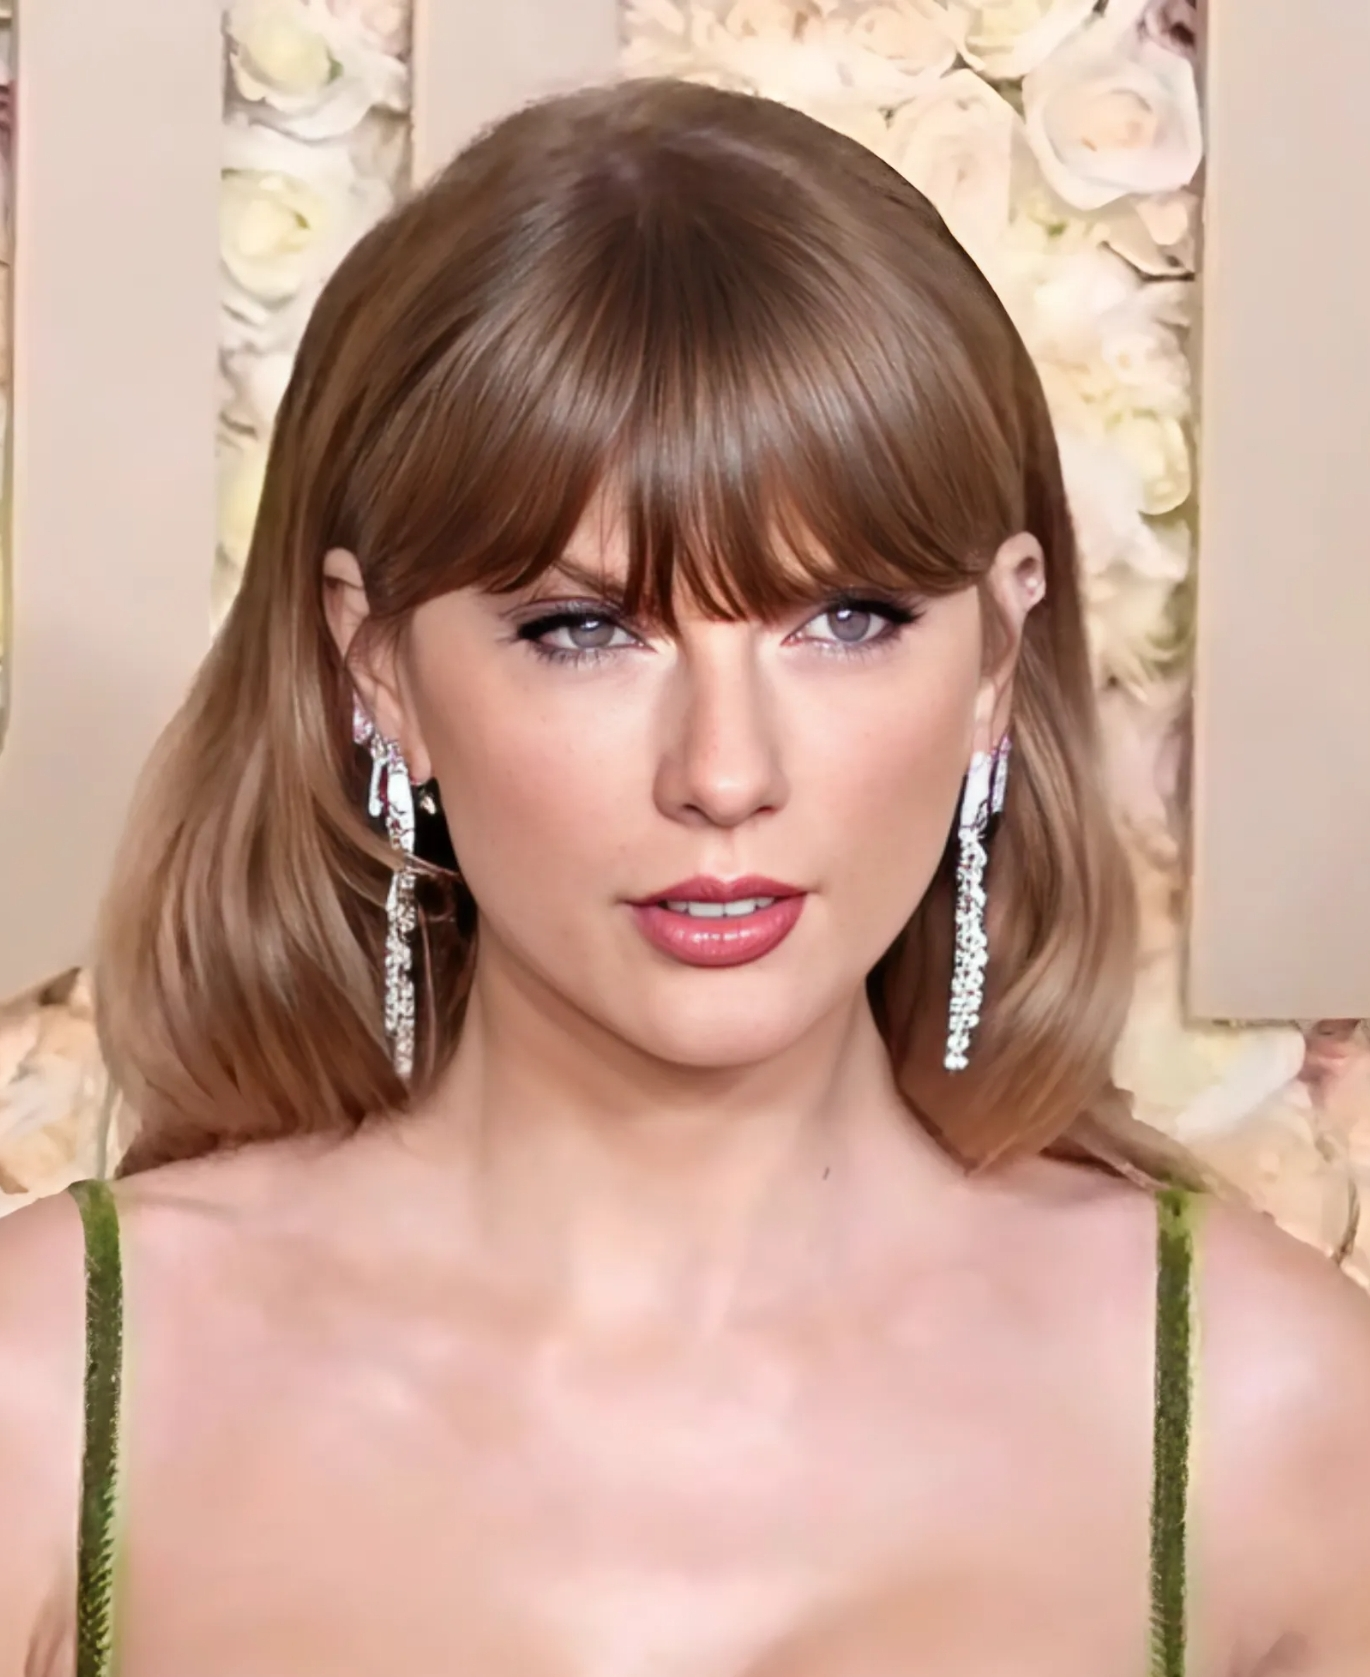

In [5]:
# Vraag de gebruiker om een afbeelding te uploaden
afbeelding_pad = "./Dvm.jpg" # gekozen afbeelding

# Laad de afbeelding
img = Image.open(afbeelding_pad)

# Toon de afbeelding
img.show()

In [6]:
# Herken de persoon in de afbeelding
naam_persoon = herken_persoon(afbeelding_pad)
print(f"Gherkende persoon: {naam_persoon}")

2024-11-04 18:20:18.617742: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 17509 images belonging to 105 classes.
Found 10282 images belonging to 105 classes.


/home/codespace/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 49/274 ━━━━━━━━━━━━━━━━━━━━ 2:47 745ms/step - accuracy: 0.0100 - loss: 5.5297

KeyboardInterrupt: 

In [ ]:
# Genereer beschrijving op basis van de herkende naam
beschrijving = genereer_beschrijving(naam_persoon)
    
print("Beschrijving:")
print(beschrijving)